In [1]:
import csv
import json
from collections import defaultdict
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from operator import itemgetter

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/treven/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
def load_data():
    data = []
    label = ['image_id','unixtime','rawtime','title','total_votes','reddit_id','number_of_upvotes',\
    'subreddit','number_of_downvotes','localtime','score','number_of_comments','username',\
    'undefined1','undefined2', 'undefined3']

    with open('submissions.csv') as csvfile:
        csvReader = csv.reader(csvfile)
        for row in csvReader:
            if row[0] == '#image_id':
                continue
            d = {}
            for i,elem in enumerate(row):
                if label[i]=='total_votes' or label[i]=='number_of_upvotes' or label[i]=='number_of_downvotes' or label[i]=='score' or label[i]=='number_of_comments':
                    d[label[i]] = int(elem)
                else:
                    d[label[i]] = elem
                    #judge if element it is empty
            data.append(d)
    return data

In [3]:
data = load_data()
comments_sorted_data = sorted(data, key=itemgetter('number_of_comments'), reverse=True)
votes_sorted_data = sorted(data, key=itemgetter('total_votes'), reverse=True)

In [4]:
def title():
    wordCount = defaultdict(int)
    punctuation = set(string.punctuation)

    # word count in top 25000 titles with most comment numbers
    for d in comments_sorted_data[0:25000]:
        r = ''.join([c for c in d['title'].lower() if not c in punctuation])
        for w in r.split():
            wordCount[w] += 1

    # remove English stopwords
    for w in stopwords.words("english"):
        if w in wordCount:
            wordCount.pop(w)

    #print(len(wordCount))
    counts = [(wordCount[w], w) for w in wordCount]
    counts.sort()
    counts.reverse()

    # take top 1000 words to be targets
    words = [x[1] for x in counts[:1000]]
    wordId = dict(zip(words, range(len(words))))
    wordSet = set(words)

    title_comment_list = []
    for d in data:
        title_comment_num = 0
        for i,w in enumerate(words):
            if w in d['title']:
                title_comment_num = title_comment_num + (1000-i)
        title_comment_list.append(title_comment_num)

    return title_comment_list

In [5]:
# submission time feature
def submission():
    ID = '-1'
    submission_list = []

    # original data is sorted in image_ID, count submission times before current submission
    for d in data:
        if d['image_id'] == ID:
            count = count + 1
            d['submission_time'] = count
        else:
            count = 0
            ID = d['image_id']
            d['submission_time'] = count

    for d in data:
        submission_list.append(d['submission_time'])

    return submission_list

In [6]:
# username feature
def username():
    with open('all_user_profile.json', 'r') as f:
        all_user_profile = json.load(f)
    #post_list = []
    #user_votes_list = []
    #user_votes_dict = {}
    user_comment_list = []
    user_comment_dict = {}
    for user in all_user_profile:
        #post_list.append(user.get('num_of_post'))
        #user_votes_dict[user.get('username')] = user.get('avg_votes')
        user_comment_dict[user.get('username')] = user.get('avg_comments')

    for d in data:
        if d['username']=='':
            user_comment_list.append(d['number_of_comments'])
        elif d['username'] in user_comment_dict:
            user_comment_list.append(user_comment_dict[d['username']])
        #if d['username'] in user_votes_dict:
            #user_votes_list.append(user_votes_dict[d['username']])

    return user_comment_list

In [7]:
#subreddit feature
def subreddit():
    with open('all_subreddit_profile.json', 'r') as f:
        all_subreddit_profile = json.load(f)
    #post_list = []
    sub_comment_list = []
    sub_comment_dict = {}
    sub_votes_list = []
    sub_votes_dict = {}
    for sub in all_subreddit_profile:
        # post_list.append(sub.get('num_of_post'))
        #sub_votes_dict[sub.get('subreddit')] = sub.get('avg_votes')
        sub_comment_dict[sub.get('subreddit')] = sub.get('avg_comments')

    for d in data:
        if d['subreddit']=='':
            sub_comment_list.append(d['number_of_comments'])
        elif d['subreddit'] in sub_comment_dict:
            sub_comment_list.append(sub_comment_dict[d['subreddit']])
        #if d['subreddit'] in sub_votes_dict:
            #sub_votes_list.append(sub_votes_dict[d['subreddit']])

    return sub_comment_list

In [19]:
title_comment_list = title()
submission_list = submission()
user_comment_list = username()
sub_comment_list = subreddit()

comment_feature_list = []
comment_label_list = []
for i in range(len(data)):
    large = 0
    comment_feature_list.append([title_comment_list[i],submission_list[i],user_comment_list[i],sub_comment_list[i]])
    if data[i]['number_of_comments'] > 15: large = 1
    comment_label_list.append(large)

print "feature[title_keyword,submission_time,username,subreddit]:",comment_feature_list[0]
print "label[comment_number]:",comment_label_list[0]

feature[title_keyword,submission_time,username,subreddit]: [554, 0, 518.5, 36.92905338181292]
label[comment_number]: 1


In [14]:
comment_feature_list[2]

[0, 2, 0.8732168330955777, 0.8732168330955777]

In [21]:
comment_label_list[11]

0

In [22]:
import os
import time
from sklearn import metrics
import numpy as np
import pickle

import sys

In [23]:
def naive_bayes_classifier(train_x, train_y):
    from sklearn.naive_bayes import GaussianNB
    model = GaussianNB()
    model.fit(train_x, train_y)
    return model

In [24]:
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [25]:
X_train, X_test, y_train, y_test = train_test_split(comment_feature_list, comment_label_list, random_state=4)

In [32]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [33]:
len(X_train)

99230

In [34]:
len(X_test)

33077

In [35]:
# check classification accuracy of KNN with K=5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.847809656257


In [31]:
y_pred[0:100]

array([0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0])

In [37]:
from sklearn.cross_validation import cross_val_score
knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
print(scores)

[ 0.84974302  0.84893681  0.84661897  0.84762673  0.84863449  0.8502469
  0.84561121  0.84742517  0.85075078  0.8498438 ]


In [38]:
# search for an optimal value of K for KNN
k_range = list(range(1, 31))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)

[0.82751184117706345, 0.82285599113171415, 0.84256777184319254, 0.83773052504282963, 0.84854378716114076, 0.8449662400483724, 0.85230273102892284, 0.84937015015620287, 0.85346165474150959, 0.85053915146629033, 0.85504383754912838, 0.85322986999899231, 0.85538647586415395, 0.85372367227652912, 0.85589035573919181, 0.85466088884409941, 0.85634384762672577, 0.85462057845409645, 0.85585004534918885, 0.85470119923410248, 0.85510430313413277, 0.85448956968658685, 0.85572911417917974, 0.8545903456615942, 0.85567872619167584, 0.8552957774866472, 0.8555376398266652, 0.85467096644160034, 0.85499344956162449, 0.85447949208908602]


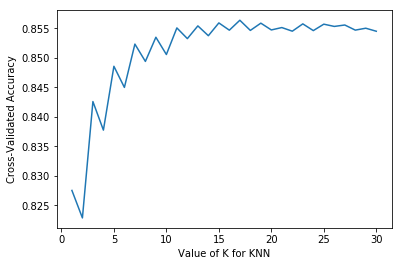

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

In [39]:
# The optimal value of K is 17
knn = KNeighborsClassifier(n_neighbors=17)
scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
print(scores.mean())

0.856343847627
